# Siamese neural network based on keras datasets

## Mnist

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from __future__ import absolute_import
from __future__ import print_function
from keras.datasets import mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.layers import Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img

In [30]:
num_classes = 10
epochs = 20

In [31]:
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true=tf.dtypes.cast(y_true, tf.float64)
    y_pred=tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def create_pairs(x, digit_indices):
  pairs = []
  labels = []
   
  n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
   
  for d in range(num_classes):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)

In [32]:
def create_base_net(input_shape):
  input = Input(shape=input_shape)
  x = Conv2D(32, (3, 3), activation='relu')(input)
  x = MaxPool2D(pool_size=(2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)
  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  model = Model(input, x)
  model.summary()
  return model

In [33]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
 
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [34]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (1, 28, 28)
print(f'{x_train.shape=}')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
x_train /= 255
x_test /= 255
 
input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)

x_train.shape=(60000, 28, 28, 1)


In [35]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)
 
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
 
base_network = create_base_net(input_shape)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 128)         7385

In [36]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
 
processed_a = base_network(input_a)
processed_b = base_network(input_b)
 
distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])
 
model = Model([input_a, input_b], distance)

In [37]:
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])

In [38]:
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 64s 75ms/step - loss: 0.0574 - accuracy: 0.9564 - val_loss: 0.0311 - val_accuracy: 0.9828
Epoch 2/20
847/847 [==============================] - 65s 77ms/step - loss: 0.0248 - accuracy: 0.9851 - val_loss: 0.0212 - val_accuracy: 0.9862
Epoch 3/20
847/847 [==============================] - 64s 75ms/step - loss: 0.0168 - accuracy: 0.9900 - val_loss: 0.0180 - val_accuracy: 0.9874
Epoch 4/20
847/847 [==============================] - 64s 75ms/step - loss: 0.0124 - accuracy: 0.9932 - val_loss: 0.0171 - val_accuracy: 0.9868
Epoch 5/20
847/847 [==============================] - 64s 76ms/step - loss: 0.0099 - accuracy: 0.9948 - val_loss: 0.0144 - val_accuracy: 0.9881
Epoch 6/20
847/847 [==============================] - 65s 77ms/step - loss: 0.0079 - accuracy: 0.9962 - val_loss: 0.0143 - val_accuracy: 0.9867
Epoch 7/20
847/847 [==============================] - 65s 77ms/step - loss: 0.0065 - accuracy: 0.9973 - val_loss: 0.0148 - val_accuracy:

In [39]:
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]], verbose=0)
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]], verbose=0)
te_acc = compute_accuracy(te_y, y_pred)
 
print(f'* Accuracy on training set: {(100 * tr_acc):.2f}')
print(f'* Accuracy on test set: {(100 * te_acc):.2f}')

* Accuracy on training set: 99.91
* Accuracy on test set: 98.01


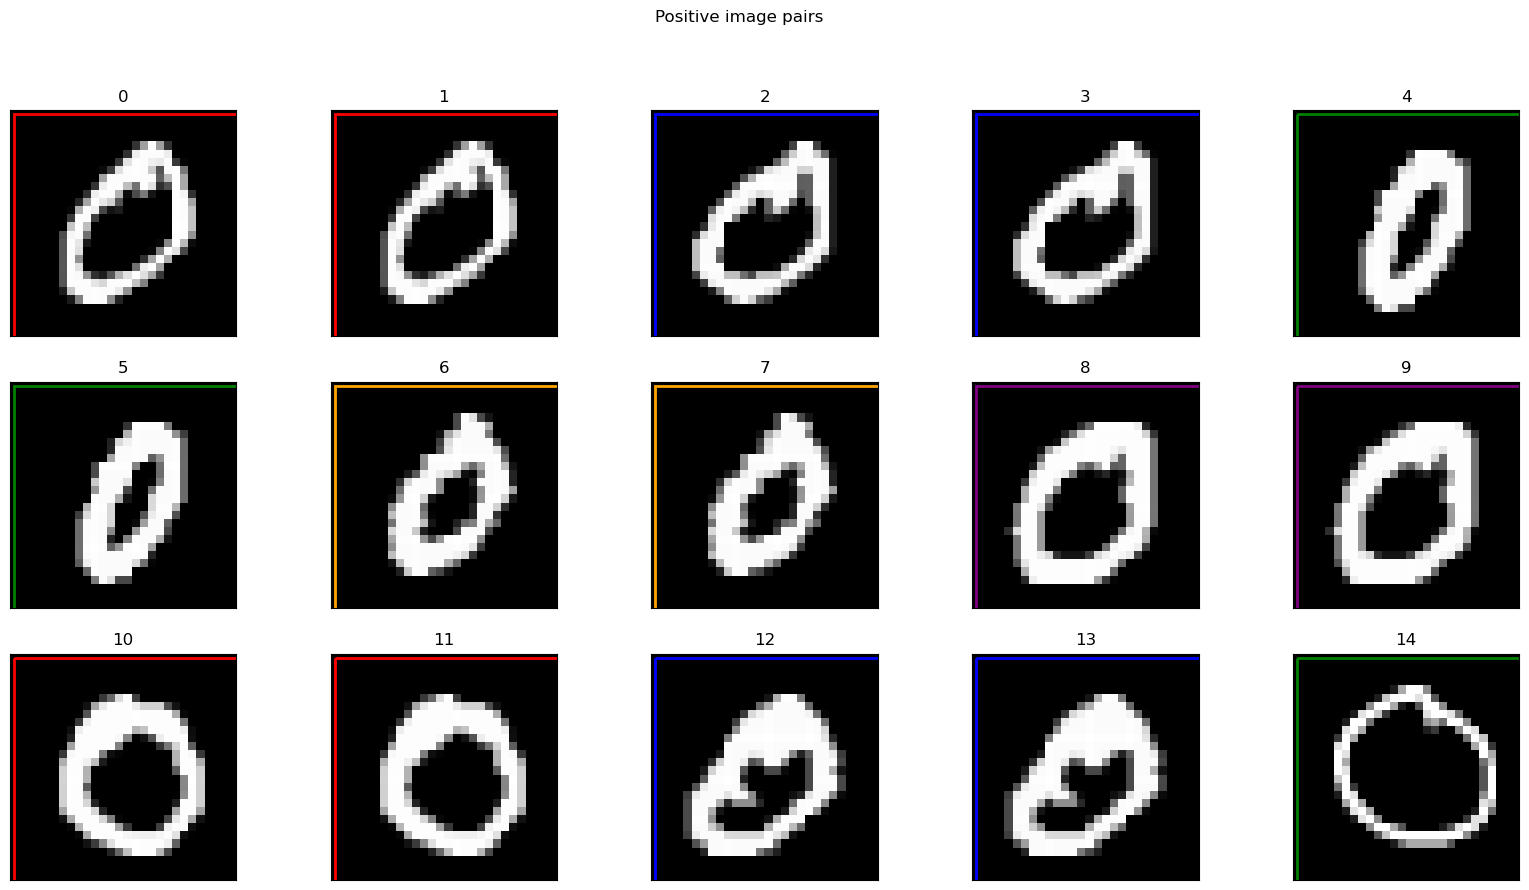

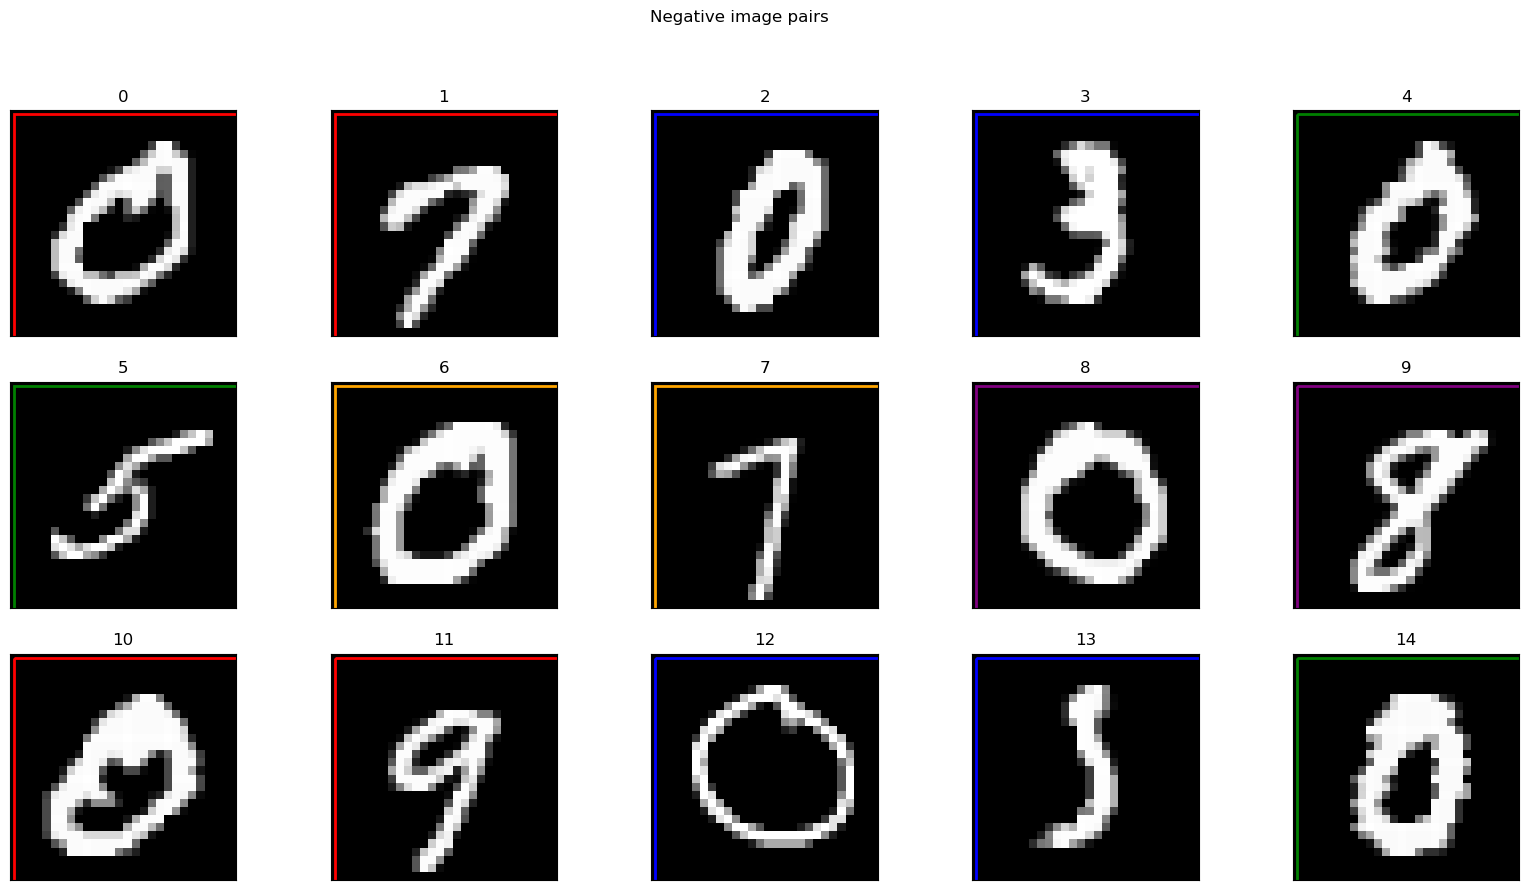

557/557 [==============================] - 2s 4ms/step


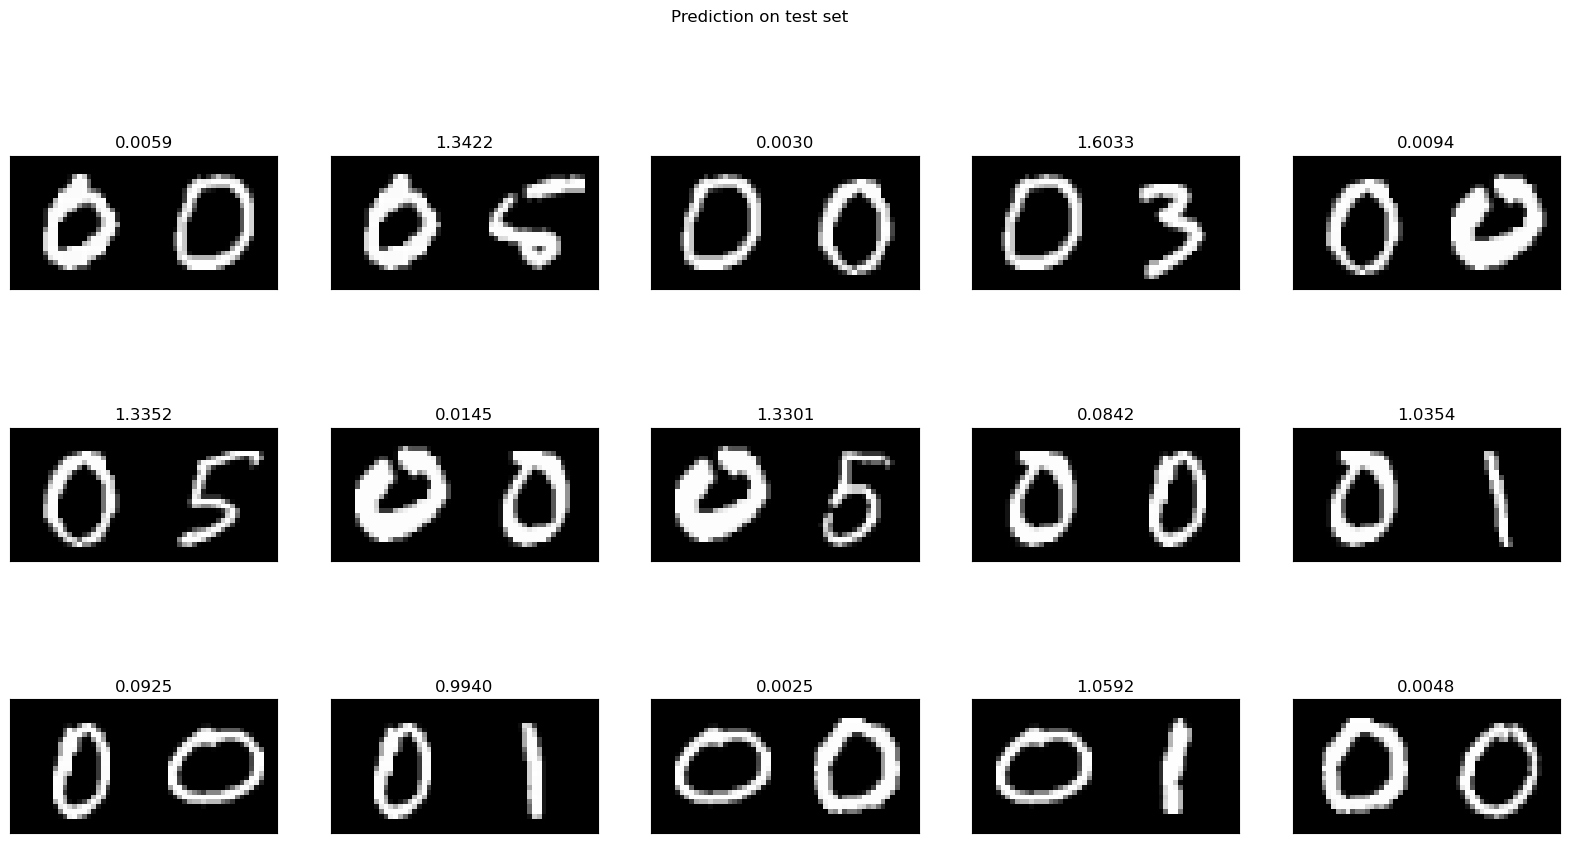

Pair 0, Predicted distance: 0.0059
Pair 1, Predicted distance: 1.3422
Pair 2, Predicted distance: 0.0030
Pair 3, Predicted distance: 1.6033
Pair 4, Predicted distance: 0.0094
Pair 5, Predicted distance: 1.3352
Pair 6, Predicted distance: 0.0145
Pair 7, Predicted distance: 1.3301
Pair 8, Predicted distance: 0.0842
Pair 9, Predicted distance: 1.0354
Pair 10, Predicted distance: 0.0925
Pair 11, Predicted distance: 0.9940
Pair 12, Predicted distance: 0.0025
Pair 13, Predicted distance: 1.0592
Pair 14, Predicted distance: 0.0048


In [40]:
number_of_items = 15
rows = 3
cols = 5

colors = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(rows, cols, item + 1)
    img_a = array_to_img(tr_pairs[item, 0], data_format=None, scale=True, dtype=None)
    plt.imshow(img_a, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
    color = colors[(item // 2) % len(colors)]
    plt.gca().add_patch(plt.Rectangle((0, 0), 32, 32, linewidth=2, edgecolor=color, facecolor='none'))
    plt.title(item)
plt.suptitle("Positive image pairs")
plt.show()

plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(rows, cols, item + 1)
    img_b = array_to_img(tr_pairs[item, 1], data_format=None, scale=True, dtype=None)
    plt.imshow(img_b, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
    color = colors[(item // 2) % len(colors)]
    plt.gca().add_patch(plt.Rectangle((0, 0), 32, 32, linewidth=2, edgecolor=color, facecolor='none'))
    plt.title(item)
plt.suptitle("Negative image pairs")
plt.show()

y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])

plt.figure(figsize=(20, 10))
for i in range(number_of_items):
    display = plt.subplot(rows, cols, i + 1)
    img_a = array_to_img(te_pairs[i, 0], data_format=None, scale=True, dtype=None)
    img_b = array_to_img(te_pairs[i, 1], data_format=None, scale=True, dtype=None)
    combined_img = np.hstack((np.array(img_a), np.array(img_b)))
    plt.imshow(combined_img, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
    plt.title(f"{y_pred[i][0]:.4f}")
plt.suptitle("Prediction on test set")
plt.show()

for i in range(number_of_items):
    print(f"Pair {i}, Predicted distance: {y_pred[i][0]:.4f}")

## Cifar10

In [41]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

num_classes = 10
epochs = 20

In [42]:
digit_indices_train = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices_train)

digit_indices_test = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices_test)

input_shape = (32, 32, 3)

base_network = create_base_net(input_shape)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 128)         7385

In [43]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [44]:
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])

In [45]:
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
782/782 [==============================] - 43s 54ms/step - loss: 0.2105 - accuracy: 0.6648 - val_loss: 0.2011 - val_accuracy: 0.6886
Epoch 2/20
782/782 [==============================] - 42s 53ms/step - loss: 0.1873 - accuracy: 0.7156 - val_loss: 0.1893 - val_accuracy: 0.7089
Epoch 3/20
782/782 [==============================] - 42s 53ms/step - loss: 0.1750 - accuracy: 0.7418 - val_loss: 0.1774 - val_accuracy: 0.7359
Epoch 4/20
782/782 [==============================] - 41s 53ms/step - loss: 0.1647 - accuracy: 0.7605 - val_loss: 0.1757 - val_accuracy: 0.7359
Epoch 5/20
782/782 [==============================] - 42s 54ms/step - loss: 0.1576 - accuracy: 0.7749 - val_loss: 0.1716 - val_accuracy: 0.7442
Epoch 6/20
782/782 [==============================] - 41s 53ms/step - loss: 0.1508 - accuracy: 0.7912 - val_loss: 0.1726 - val_accuracy: 0.7414
Epoch 7/20
782/782 [==============================] - 41s 53ms/step - loss: 0.1450 - accuracy: 0.8012 - val_loss: 0.1762 - val_accuracy:

In [46]:
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]], verbose=0)
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]], verbose=0)
te_acc = compute_accuracy(te_y, y_pred)
 
print(f'* Accuracy on training set: {(100 * tr_acc):.2f}')
print(f'* Accuracy on test set: {(100 * te_acc):.2f}')

* Accuracy on training set: 89.27
* Accuracy on test set: 73.32


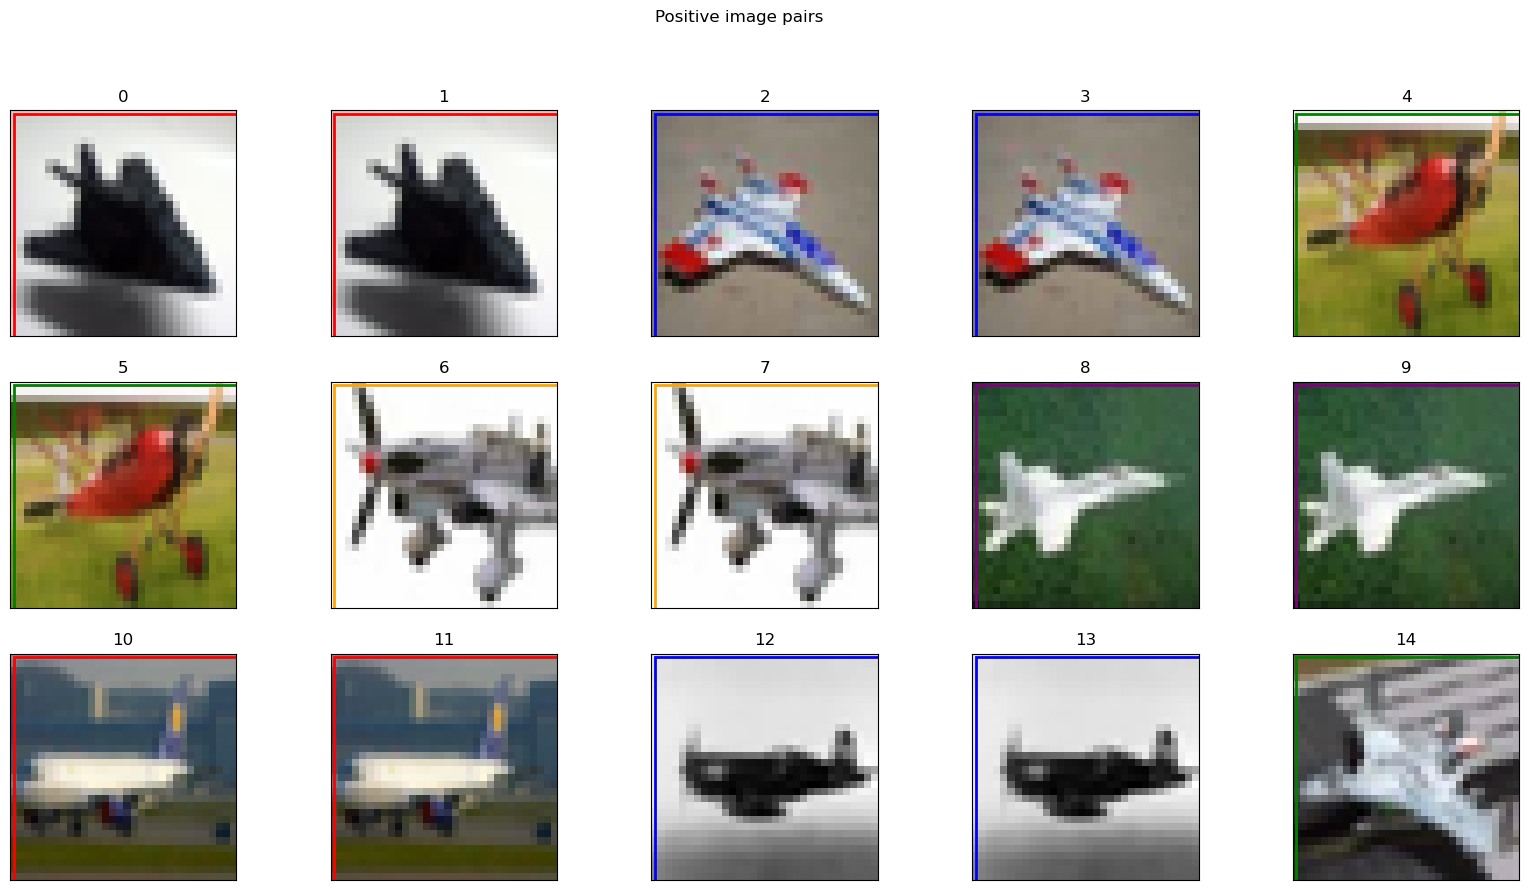

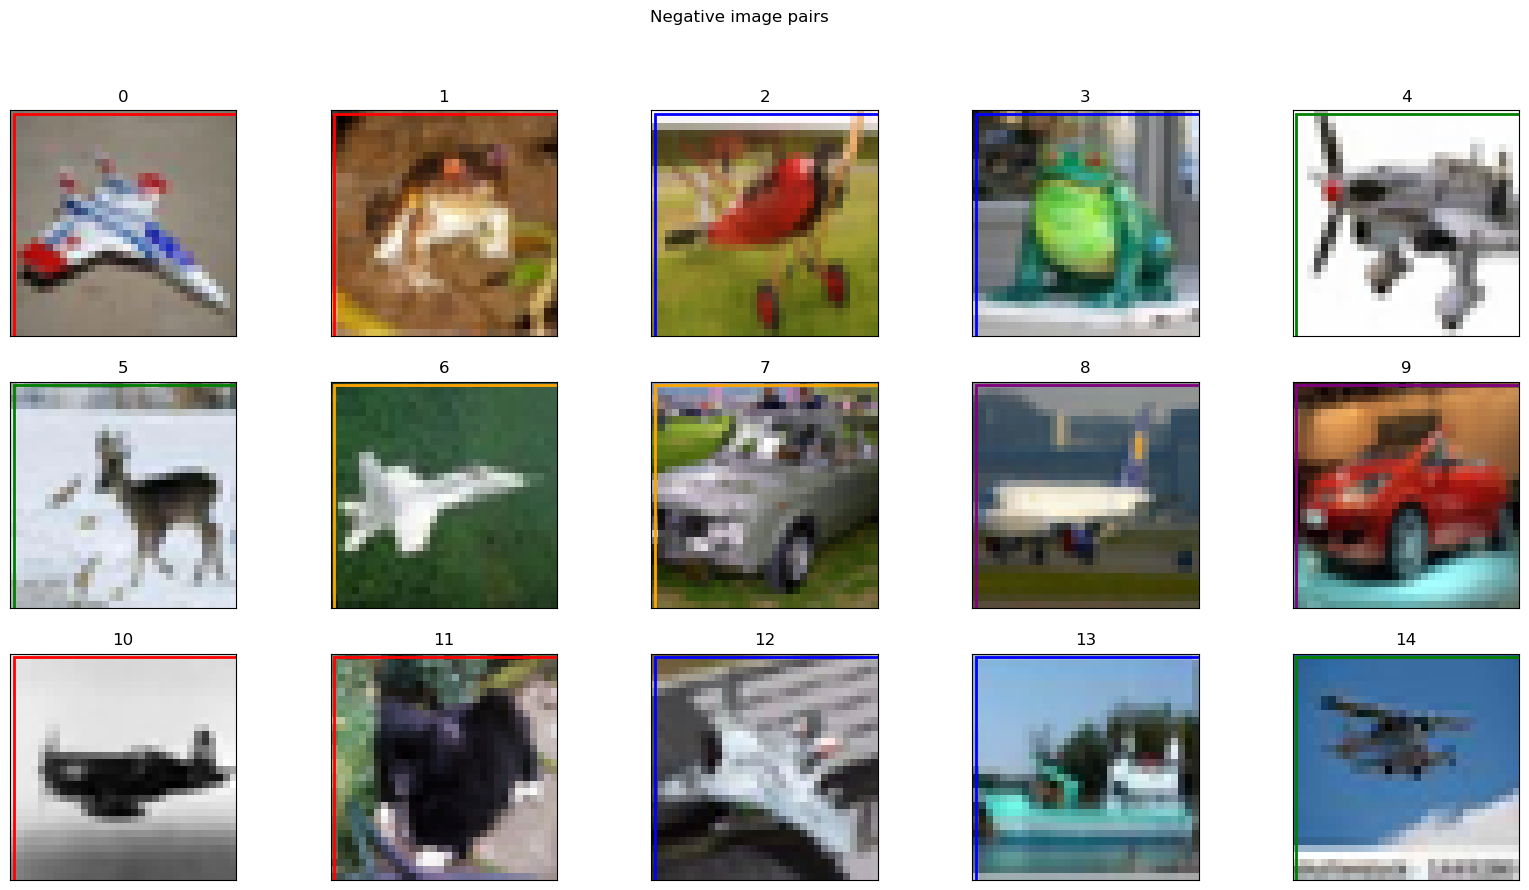

625/625 [==============================] - 4s 6ms/step


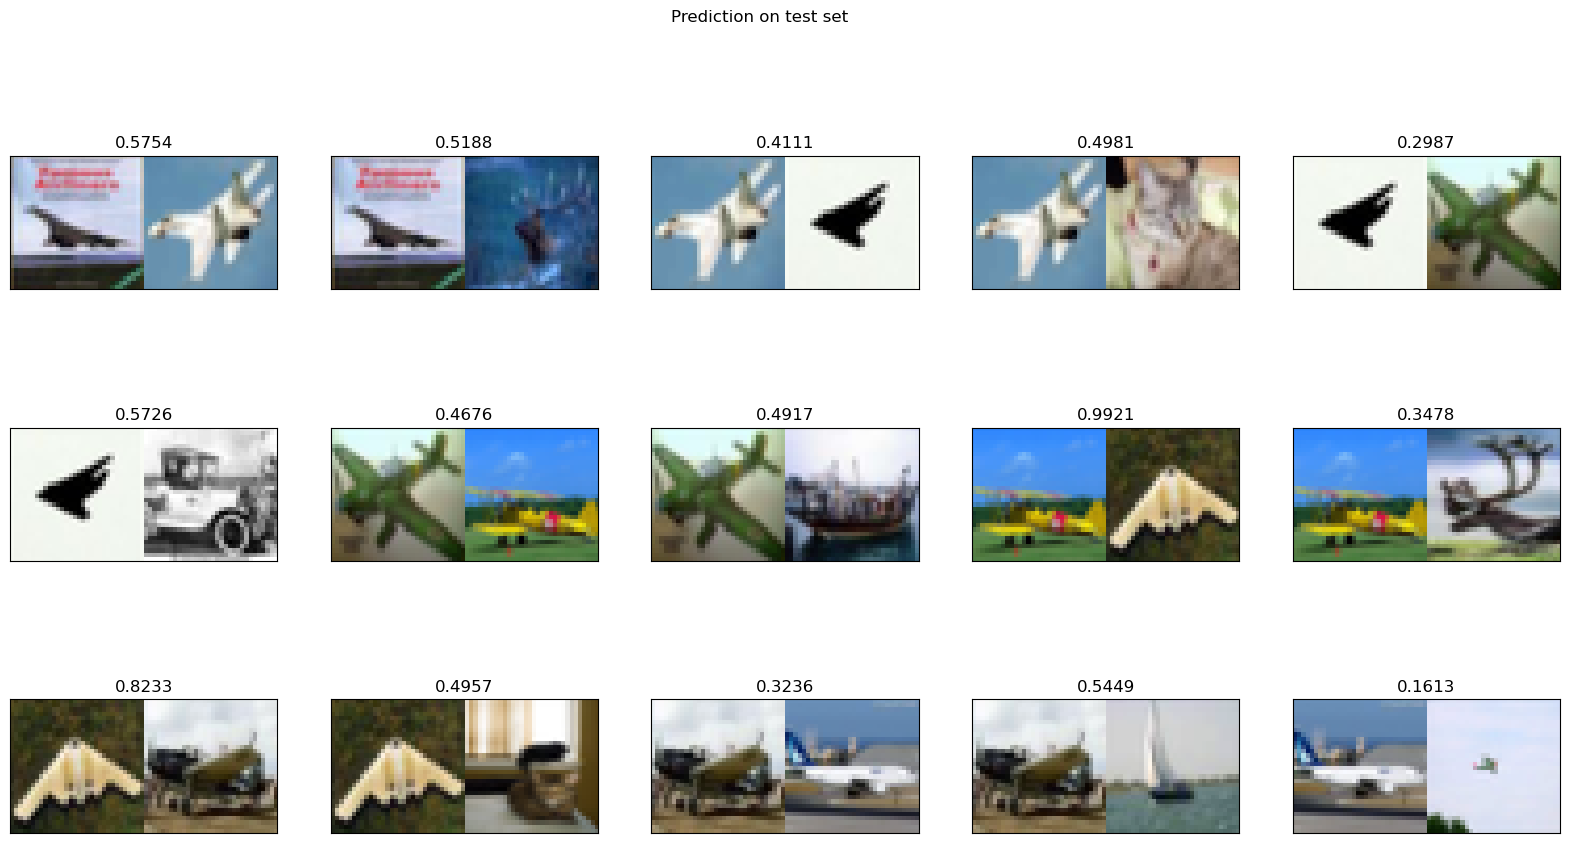

Pair 0, Predicted distance: 0.5754
Pair 1, Predicted distance: 0.5188
Pair 2, Predicted distance: 0.4111
Pair 3, Predicted distance: 0.4981
Pair 4, Predicted distance: 0.2987
Pair 5, Predicted distance: 0.5726
Pair 6, Predicted distance: 0.4676
Pair 7, Predicted distance: 0.4917
Pair 8, Predicted distance: 0.9921
Pair 9, Predicted distance: 0.3478
Pair 10, Predicted distance: 0.8233
Pair 11, Predicted distance: 0.4957
Pair 12, Predicted distance: 0.3236
Pair 13, Predicted distance: 0.5449
Pair 14, Predicted distance: 0.1613


In [47]:
number_of_items = 15
rows = 3
cols = 5

colors = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(rows, cols, item + 1)
    img_a = tf.keras.preprocessing.image.array_to_img(tr_pairs[item, 0], data_format=None, scale=True, dtype=None)
    plt.imshow(img_a)
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
    color = colors[(item // 2) % len(colors)]
    plt.gca().add_patch(plt.Rectangle((0, 0), 32, 32, linewidth=2, edgecolor=color, facecolor='none'))
    plt.title(item)
plt.suptitle("Positive image pairs")
plt.show()

plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(rows, cols, item + 1)
    img_b = tf.keras.preprocessing.image.array_to_img(tr_pairs[item, 1], data_format=None, scale=True, dtype=None)
    plt.imshow(img_b)
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
    color = colors[(item // 2) % len(colors)]
    plt.gca().add_patch(plt.Rectangle((0, 0), 32, 32, linewidth=2, edgecolor=color, facecolor='none'))
    plt.title(item)
plt.suptitle("Negative image pairs")
plt.show()

y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])

plt.figure(figsize=(20, 10))
for i in range(number_of_items):
    display = plt.subplot(rows, cols, i + 1)
    img_a = tf.keras.preprocessing.image.array_to_img(te_pairs[i, 0], data_format=None, scale=True, dtype=None)
    img_b = tf.keras.preprocessing.image.array_to_img(te_pairs[i, 1], data_format=None, scale=True, dtype=None)
    combined_img = np.hstack((np.array(img_a), np.array(img_b)))
    plt.imshow(combined_img)
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
    plt.title(f"{y_pred[i][0]:.4f}")
plt.suptitle("Prediction on test set")
plt.show()

for i in range(number_of_items):
    print(f"Pair {i}, Predicted distance: {y_pred[i][0]:.4f}")